<cell_type>markdown</cell_type># 3D FEA — scikit-fem (Extruded Geometry)

Full 3D finite element analysis of the CCS bistable **half-beam** using `scikit-fem`.

The half-beam polygon is extruded by the structural thickness (0.5 µm) in the z-direction
using `gmsh`. No plane strain assumption — full 3D elasticity.

**Boundary conditions**:
- Anchor (x≈0): clamped, u_x = u_y = u_z = 0
- Shuttle (x≈L): prescribe u_y, u_x and u_z free

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

import gmsh
import meshio
import skfem
from skfem import *
from skfem.models.elasticity import linear_elasticity, lame_parameters
from skfem.helpers import ddot, transpose, grad

sys.path.insert(0, os.path.dirname(os.path.abspath("__file__")))
from beam_utils import (
    POLY_SI, DEFAULT_BEAM_PARAMS, get_beam_polygon,
    get_beam_centerline,
)

L = DEFAULT_BEAM_PARAMS["half_span"]   # 20 µm
h = DEFAULT_BEAM_PARAMS["initial_offset"]  # 1.2 µm
t = POLY_SI["t"]
E = POLY_SI["E"]
nu = POLY_SI["nu"]
lam, mu = lame_parameters(E, nu)
print(f"Half-beam: L={L} µm, h={h} µm, t={t} µm")
print(f"E={E/1e3:.0f} GPa, ν={nu}, λ={lam:.1f} MPa, μ={mu:.1f} MPa")

Half-beam: L=20.0 µm, h=1.2 µm, t=0.5 µm
E=160 GPa, ν=0.22, λ=51522.2 MPa, μ=65573.8 MPa


## 1. 3D Mesh Generation with gmsh

In [2]:
poly = get_beam_polygon(n_points=300)
if np.allclose(poly[0], poly[-1]):
    poly = poly[:-1]

gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 0)
gmsh.model.add("ccs_beam_3d")

# Coarser mesh for tractable 3D solve times
lc_flex = 0.3
lc_rigid = 0.5

# Flex region extent
L_flex = DEFAULT_BEAM_PARAMS["flex_ratio"] * L

point_tags = []
for i, (x, y) in enumerate(poly):
    in_flex = (x < L_flex + 1) or (x > L - L_flex - 1)
    lc = lc_flex if in_flex else lc_rigid
    tag = gmsh.model.occ.addPoint(x, y, 0, lc)
    point_tags.append(tag)

line_tags = []
n_pts = len(point_tags)
for i in range(n_pts):
    j = (i + 1) % n_pts
    tag = gmsh.model.occ.addLine(point_tags[i], point_tags[j])
    line_tags.append(tag)

wire = gmsh.model.occ.addCurveLoop(line_tags)
surf = gmsh.model.occ.addPlaneSurface([wire])

# Extrude by thickness
n_layers_z = 3
extrude = gmsh.model.occ.extrude([(2, surf)], 0, 0, t,
                                  numElements=[n_layers_z], recombine=False)

gmsh.model.occ.synchronize()
gmsh.model.mesh.generate(3)

tmp_msh = '/tmp/ccs_beam_3d.msh'
gmsh.write(tmp_msh)

node_tags, coords, _ = gmsh.model.mesh.getNodes()
print(f"gmsh 3D mesh: {len(node_tags)} nodes")
gmsh.finalize()

gmsh 3D mesh: 14544 nodes


In [3]:
# Read mesh with meshio and convert to scikit-fem
msh = meshio.read(tmp_msh)

# Extract tetrahedral cells
tet_cells = None
for cell_block in msh.cells:
    if cell_block.type == 'tetra':
        tet_cells = cell_block.data
        break

if tet_cells is None:
    raise RuntimeError("No tetrahedral elements found in mesh")

points = msh.points
print(f"Mesh: {len(points)} nodes, {len(tet_cells)} tetrahedra")

# Create scikit-fem MeshTet
mesh3d = MeshTet(points.T, tet_cells.T)
print(f"scikit-fem mesh: {mesh3d.nvertices} vertices, {mesh3d.nelements} elements")

Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


Mesh: 14544 nodes, 60012 tetrahedra
scikit-fem mesh: 14544 vertices, 60012 elements


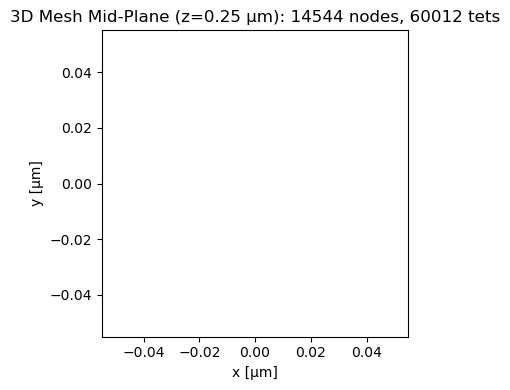

In [4]:
# Visualize mesh (xy-projection)
fig, ax = plt.subplots(figsize=(14, 4))

# Plot the mid-plane nodes
z_mid = t / 2
mid_mask = np.abs(mesh3d.p[2] - z_mid) < 0.05
ax.plot(mesh3d.p[0, mid_mask], mesh3d.p[1, mid_mask], 'k.', ms=0.5)
ax.set_aspect('equal')
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
ax.set_title(f'3D Mesh Mid-Plane (z={z_mid} µm): {mesh3d.nvertices} nodes, {mesh3d.nelements} tets')

fig.tight_layout()
fig.savefig('plots/skfem_3d_mesh.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Boundary Identification

In [5]:
tol = 0.05

# Anchor nodes (x ≈ 0): fully clamped
anchor_nodes_3d = np.where(mesh3d.p[0] < tol)[0]

# Shuttle nodes (x ≈ L): prescribe y-displacement
shuttle_nodes_3d = np.where(mesh3d.p[0] > L - tol)[0]

print(f"Anchor nodes: {len(anchor_nodes_3d)}")
print(f"Shuttle nodes: {len(shuttle_nodes_3d)}")

Anchor nodes: 12
Shuttle nodes: 12


## 3. Linear Elasticity Sweep (3D)

In [6]:
# 3D element and basis
elem3d = ElementTetP1()
ib3d = Basis(mesh3d, ElementVector(elem3d))

N3d = mesh3d.nvertices
ndofs_3d = 3 * N3d
print(f"Per-element DOFs: {ib3d.Nbfun}")
print(f"System DOFs: {ndofs_3d} ({N3d} vertices × 3 components)")

# Assemble linear stiffness
K3d = linear_elasticity(lam, mu).assemble(ib3d)
assert K3d.shape[0] == ndofs_3d
print(f"Stiffness matrix: {K3d.shape[0]}×{K3d.shape[1]}")

# DOF layout for 3D ElementVector(P1): INTERLEAVED [x0,y0,z0, x1,y1,z1, ...]
# Node i: x = 3*i, y = 3*i+1, z = 3*i+2
anchor_x = 3 * anchor_nodes_3d
anchor_y = 3 * anchor_nodes_3d + 1
anchor_z = 3 * anchor_nodes_3d + 2
fixed_dofs_3d = np.concatenate([anchor_x, anchor_y, anchor_z])

# Shuttle: prescribe y only
shuttle_y_dofs_3d = 3 * shuttle_nodes_3d + 1

print(f"Fixed DOFs (anchor): {len(fixed_dofs_3d)}")
print(f"Prescribed DOFs (shuttle y): {len(shuttle_y_dofs_3d)}")

Per-element DOFs: 12
System DOFs: 43632 (14544 vertices × 3 components)
Stiffness matrix: 43632×43632
Fixed DOFs (anchor): 36
Prescribed DOFs (shuttle y): 12


In [7]:
# Linear sweep
n_disp_3d = 30
delta_3d = np.linspace(0, -2*h, n_disp_3d)
F_linear_3d = np.zeros(n_disp_3d)

all_bc_3d = np.concatenate([fixed_dofs_3d, shuttle_y_dofs_3d])

for i, delta in enumerate(delta_3d):
    x_pre = np.zeros(ndofs_3d)
    x_pre[shuttle_y_dofs_3d] = delta
    
    u = solve(*condense(K3d, np.zeros(ndofs_3d), D=all_bc_3d, x=x_pre))
    
    f_react = K3d @ u
    F_linear_3d[i] = np.sum(f_react[shuttle_y_dofs_3d])
    
    if i % 10 == 0:
        print(f"  Step {i}/{n_disp_3d}: δ={delta:.3f} µm, F={F_linear_3d[i]:.4f} µN")

print(f"Linear 3D sweep complete. F range: [{F_linear_3d.min():.4f}, {F_linear_3d.max():.4f}] µN")

  Step 0/30: δ=0.000 µm, F=0.0000 µN
  Step 10/30: δ=-0.828 µm, F=-0.3733 µN
  Step 20/30: δ=-1.655 µm, F=-0.7467 µN
Linear 3D sweep complete. F range: [-1.0826, 0.0000] µN


## 4. Nonlinear Sweep (3D Total Lagrangian)

In [8]:
from skfem.assembly import BilinearForm, LinearForm

# Identity matrix for 3D tensor fields
I3 = np.eye(3).reshape(3, 3, 1, 1)

def mat(A, B):
    """Matrix-matrix product for (3,3,...) tensor fields."""
    return np.einsum('ij...,jk...->ik...', A, B)

@BilinearForm
def stiffness_nl_3d(u, v, w):
    """3D tangent stiffness: Total Lagrangian, St. Venant-Kirchhoff."""
    du = grad(w['prev'])
    F = I3 + du
    GL = 0.5 * (mat(transpose(F), F) - I3)
    trE = GL[0,0] + GL[1,1] + GL[2,2]
    S = lam * trE * I3 + 2.0 * mu * GL
    
    dv = grad(v)
    dw = grad(u)
    
    dGL = 0.5 * (mat(transpose(F), dw) + mat(transpose(dw), F))
    trDE = dGL[0,0] + dGL[1,1] + dGL[2,2]
    dS = lam * trDE * I3 + 2.0 * mu * dGL
    dGL_v = 0.5 * (mat(transpose(F), dv) + mat(transpose(dv), F))
    
    k_mat = ddot(dS, dGL_v)
    k_geo = ddot(S, 0.5 * (mat(transpose(dw), dv) + mat(transpose(dv), dw)))
    return k_mat + k_geo

@LinearForm
def internal_forces_3d(v, w):
    """3D internal force vector."""
    du = grad(w['prev'])
    F = I3 + du
    GL = 0.5 * (mat(transpose(F), F) - I3)
    trE = GL[0,0] + GL[1,1] + GL[2,2]
    S = lam * trE * I3 + 2.0 * mu * GL
    dv = grad(v)
    dGL_v = 0.5 * (mat(transpose(F), dv) + mat(transpose(dv), F))
    return ddot(S, dGL_v)

print("3D nonlinear forms defined.")

3D nonlinear forms defined.


In [9]:
# Nonlinear sweep — reduced steps for tractable 3D runtime
n_nl_3d = 30
delta_nl_3d = np.linspace(0, -2*h, n_nl_3d)
F_nl_3d = np.zeros(n_nl_3d)

u_curr_3d = np.zeros(ndofs_3d)
max_newton = 40
nl_tol = 1e-6

for i, delta in enumerate(delta_nl_3d):
    u_iter = u_curr_3d.copy()
    u_iter[fixed_dofs_3d] = 0.0
    u_iter[shuttle_y_dofs_3d] = delta
    
    converged = False
    for nit in range(max_newton):
        u_field = ib3d.interpolate(u_iter)
        Kt = stiffness_nl_3d.assemble(ib3d, prev=u_field)
        fint = internal_forces_3d.assemble(ib3d, prev=u_field)
        
        residual = fint.copy()
        residual[all_bc_3d] = 0.0
        
        rn = np.linalg.norm(residual)
        if rn < nl_tol:
            converged = True
            break
        
        du_c = solve(*condense(Kt, -residual, D=all_bc_3d))
        u_iter += du_c
    
    if not converged and i > 0:
        print(f"  Step {i}: δ={delta:.4f}, not converged (res={rn:.2e})")
    
    u_curr_3d = u_iter.copy()
    
    u_field = ib3d.interpolate(u_curr_3d)
    fint = internal_forces_3d.assemble(ib3d, prev=u_field)
    F_nl_3d[i] = np.sum(fint[shuttle_y_dofs_3d])
    
    if i % 10 == 0:
        print(f"  Step {i}/{n_nl_3d}: δ={delta:.3f} µm, F={F_nl_3d[i]:.4f} µN, "
              f"Newton iters={nit+1}")

print(f"Nonlinear 3D sweep complete. F range: [{F_nl_3d.min():.4f}, {F_nl_3d.max():.4f}] µN")

  Step 0/30: δ=0.000 µm, F=0.0000 µN, Newton iters=1
  Step 10/30: δ=-0.828 µm, F=-0.3884 µN, Newton iters=13
  Step 20/30: δ=-1.655 µm, F=-0.8565 µN, Newton iters=12
Nonlinear 3D sweep complete. F range: [-1.3718, 0.0000] µN


## 5. Results

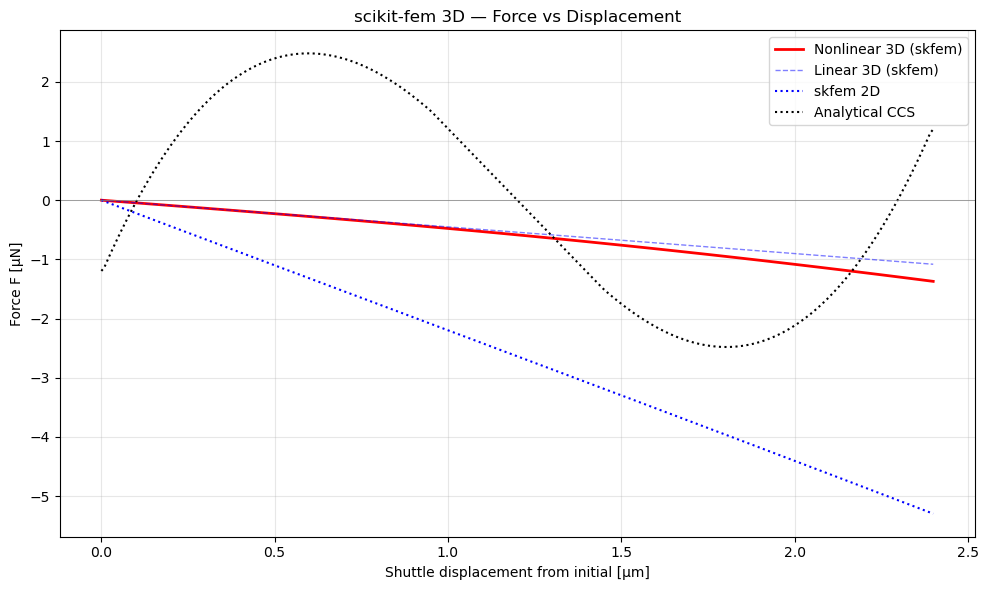

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(-delta_nl_3d, F_nl_3d, 'r-', linewidth=2, label='Nonlinear 3D (skfem)')
ax.plot(-delta_3d, F_linear_3d, 'b--', linewidth=1, alpha=0.5, label='Linear 3D (skfem)')

for fname, label, style in [
    ('results/skfem_2d_force_displacement.csv', 'skfem 2D', 'b:'),
    ('results/analytical_force_displacement.csv', 'Analytical CCS', 'k:'),
]:
    try:
        data = np.loadtxt(fname, delimiter=',', skiprows=1)
        col = 2 if 'analytical' in fname else 1
        ax.plot(data[:, 0], data[:, col], style, linewidth=1.5, label=label)
    except FileNotFoundError:
        pass

ax.axhline(0, color='gray', linewidth=0.5)
ax.set_xlabel('Shuttle displacement from initial [µm]')
ax.set_ylabel('Force F [µN]')
ax.set_title('scikit-fem 3D — Force vs Displacement')
ax.legend()
ax.grid(True, alpha=0.3)

fig.tight_layout()
fig.savefig('plots/skfem_3d_force_displacement.png', dpi=150, bbox_inches='tight')
plt.show()

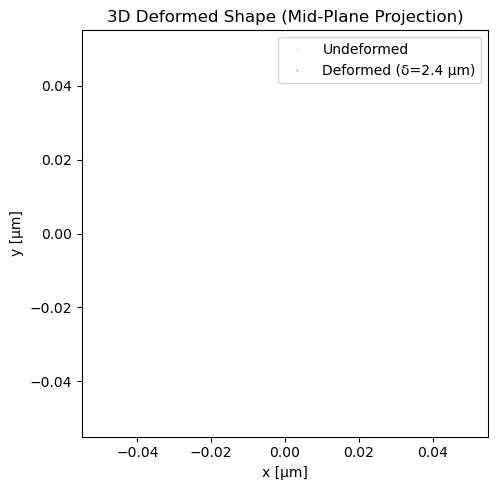

In [11]:
# Deformed shape visualization (mid-plane)
fig, ax = plt.subplots(figsize=(14, 5))

# Interleaved DOF layout: [x0,y0,z0, x1,y1,z1, ...]
ux_3d = u_curr_3d[0::3]
uy_3d = u_curr_3d[1::3]

z_vals = mesh3d.p[2]
z_mid = t / 2
mid_mask = np.abs(z_vals - z_mid) < 0.08

ax.plot(mesh3d.p[0, mid_mask], mesh3d.p[1, mid_mask], 'k.', ms=0.3, alpha=0.3,
        label='Undeformed')
ax.plot(mesh3d.p[0, mid_mask] + ux_3d[mid_mask],
        mesh3d.p[1, mid_mask] + uy_3d[mid_mask],
        'r.', ms=0.5, label=f'Deformed (δ={2*h:.1f} µm)')

ax.set_aspect('equal')
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
ax.set_title('3D Deformed Shape (Mid-Plane Projection)')
ax.legend()

fig.tight_layout()
fig.savefig('plots/skfem_3d_deformed_shape.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# Save results
np.savetxt('results/skfem_3d_force_displacement.csv',
           np.column_stack([-delta_nl_3d, F_nl_3d]),
           delimiter=',',
           header='delta_um,F_uN',
           comments='')

print("Saved: results/skfem_3d_force_displacement.csv")

Saved: results/skfem_3d_force_displacement.csv
